In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import mean_squared_error

In [2]:
# Load the Brent oil data
column_names = ["Date", "OilPrice"]
brent_data = pd.read_excel("https://www.eia.gov/dnav/pet/hist_xls/RBRTEd.xls", sheet_name=1, skiprows=4, engine='xlrd', names=column_names)
brent_data.dropna(inplace=True)
brent_data['Date'] = pd.to_datetime(brent_data['Date'])
brent_data.set_index('Date', inplace=True)

In [3]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
brent_data['normalized_oil_prices'] = scaler.fit_transform(brent_data[['OilPrice']])

In [4]:
# Train-test split
split_date = pd.to_datetime("2010-01-01")
cutoff_date = pd.to_datetime("2023-01-01")

In [5]:
train_data = brent_data.loc[split_date:cutoff_date]['normalized_oil_prices']
test_data = brent_data.loc[cutoff_date:]['normalized_oil_prices']
test_real = brent_data.loc[cutoff_date:]['OilPrice']
test_dates_full = brent_data.loc[cutoff_date:].index


In [6]:
# Function to create sequences for LSTM input
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

In [7]:
# Define sequence length (e.g., 60 days)
seq_length = 60
train_sequences = create_sequences(train_data.values, seq_length)
test_sequences = create_sequences(test_data.values, seq_length)

In [8]:
# Split sequences into input (X) and output (y)
X_train = train_sequences[:, :-1]
y_train = train_sequences[:, -1]

In [9]:
X_test = test_sequences[:, :-1]
y_test = test_sequences[:, -1]

In [10]:
# Reshape for LSTM input [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [11]:
# Adjust the test dates to account for the sequence length
test_dates = test_dates_full[seq_length:]


In [13]:
# Build the Bidirectional LSTM model
model = Sequential()

# First Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.001)), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))  # Dropout layer to prevent overfitting

# Second Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=50, return_sequences=False, kernel_regularizer=l2(0.001))))
model.add(Dropout(0.3))

# Additional Dense layer
model.add(Dense(units=25, activation='relu', kernel_regularizer=l2(0.001)))

# Output Dense layer for prediction
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 29s 157ms/step - loss: 0.1705 - val_loss: 0.0141
Epoch 2/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 0.0128 - val_loss: 0.0074
Epoch 3/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - loss: 0.0056 - val_loss: 0.0025
Epoch 4/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 5/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 6/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 7/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 8/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 9/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 10/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 11/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 12/25
101/101 ━━━

In [14]:
# Predict on test data
predicted_oil_prices = model.predict(X_test)
predicted_oil_prices = scaler.inverse_transform(predicted_oil_prices)  # Rescale to original values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), predicted_oil_prices))
print(f'Root Mean Squared Error: {rmse}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step
Root Mean Squared Error: 3.2659475132281375


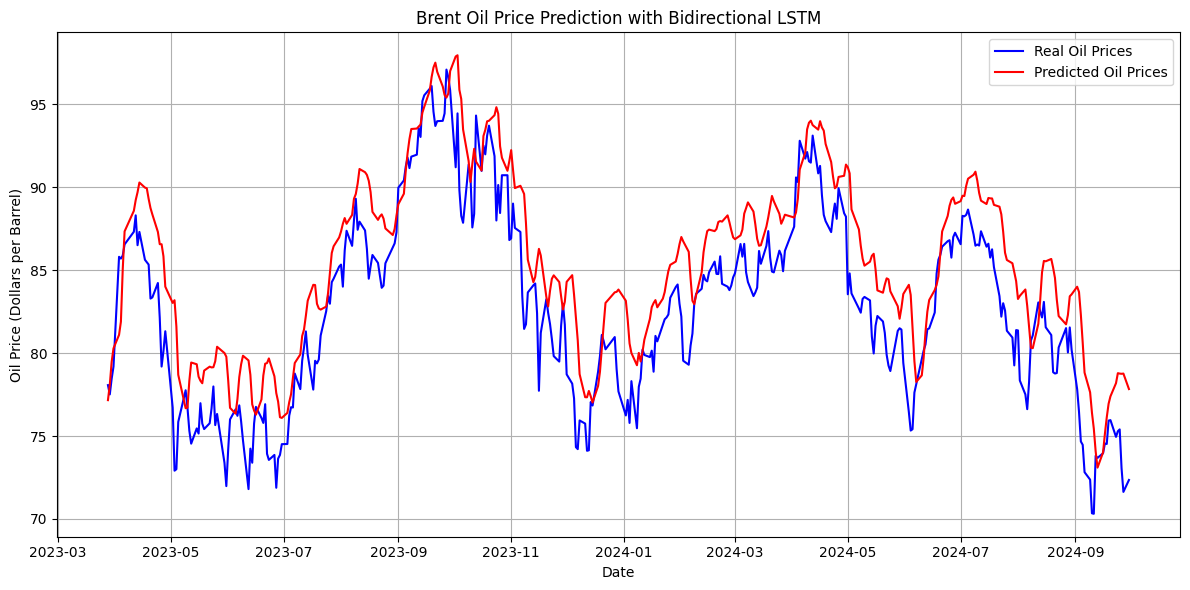

In [15]:
# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test_real[seq_length:], label='Real Oil Prices', color='blue')
plt.plot(test_dates, predicted_oil_prices, label='Predicted Oil Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Oil Price (Dollars per Barrel)')
plt.title('Brent Oil Price Prediction with Bidirectional LSTM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()